In [1]:
!cp "/content/drive/MyDrive/wifi_csi/wifi_csi/preprocessed.zip" /content/

In [2]:
!unzip -q /content/preprocessed.zip -d /content

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.signal

warnings.filterwarnings('ignore')

# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
PyTorch Version: 2.9.0+cu126
CUDA Available: True
GPU: Tesla T4


In [4]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

CONFIG = {
    # Paths
    'dataset_path': '/content/drive/MyDrive/wifi_csi',
    'preprocessed_dir': '/content/preprocessed',
    'annotation_file': '/content/annotation.csv',
    'raw_npy_dir': '/content/drive/MyDrive/wifi_csi/wifi_csi/npy',  # For visualization

    # Training
    'batch_size': 32,
    'lr': 5e-4,
    'epochs': 30,
    'num_classes': 6,
    'window': 1500,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Augmentation
    'use_augmentation': True,
    'mixup_alpha': 0.2,
    'time_mask_ratio': 0.1,
    'freq_mask_ratio': 0.1,

    # Domain Adaptation
    'use_coral': True,
    'coral_weight': 0.5,

    # Regularization
    'label_smoothing': 0.1,
    'dropout': 0.4,
    'weight_decay': 1e-4,
}

print(f"🚀 Running on Device: {CONFIG['device']}")

🚀 Running on Device: cuda


## Signal Preprocessing Visualization

This section demonstrates the preprocessing steps applied to raw CSI data:
1. **Amplitude Extraction** - Signal strength from complex CSI
2. **Phase Unwrapping** - Removes 2π discontinuities
3. **Phase Detrending** - Removes linear drift (CFO/SFO)
4. **Normalization** - Standardizes amplitude and phase

Raw CSI shape: (2644, 3, 3, 30)


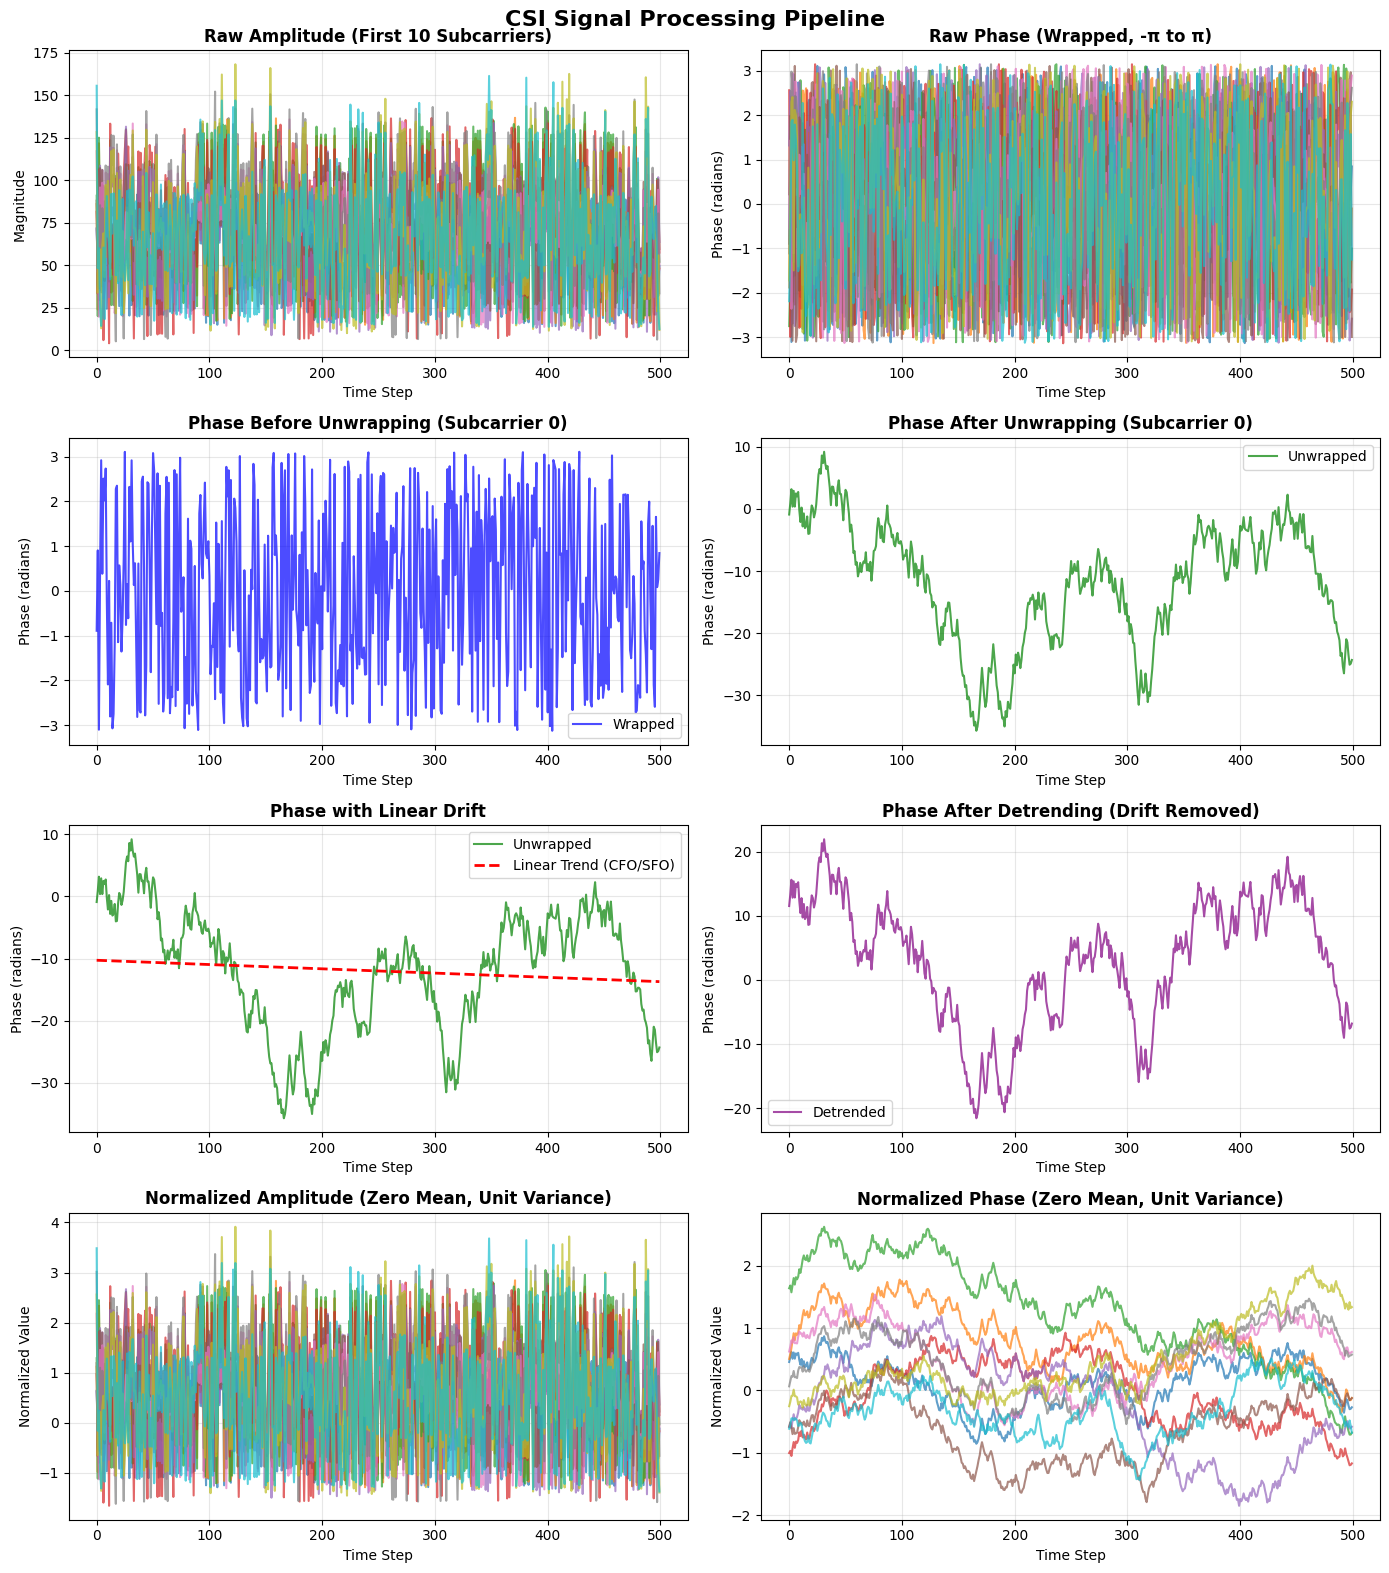


📊 Signal Processing Summary:
   Raw Amplitude Range: [0.00, 179.61]
   Normalized Amplitude Range: [-1.80, 4.30]
   Raw Phase Range: [-3.13, 3.14]
   Normalized Phase Range: [-4.44, 4.97]


In [6]:
def visualize_preprocessing_pipeline(raw_npy_path, sample_idx=0):
    """
    Visualize the signal processing pipeline on a raw CSI sample.
    """
    # Load raw complex CSI
    complex_csi = np.load(raw_npy_path)
    print(f"Raw CSI shape: {complex_csi.shape}")  # (T, 3, 3, 30)

    T = complex_csi.shape[0]

    # Extract amplitude and phase
    amplitude = np.abs(complex_csi)
    phase_raw = np.angle(complex_csi)

    # Flatten for processing
    amplitude_flat = amplitude.reshape(T, -1)  # (T, 270)
    phase_flat = phase_raw.reshape(T, -1)      # (T, 270)

    # Phase unwrapping
    phase_unwrapped = np.unwrap(phase_flat, axis=0)

    # Phase detrending
    phase_detrended = scipy.signal.detrend(phase_unwrapped, axis=0, type='linear')

    # Normalization
    amp_normalized = (amplitude_flat - amplitude_flat.mean()) / (amplitude_flat.std() + 1e-8)
    phase_normalized = (phase_detrended - phase_detrended.mean()) / (phase_detrended.std() + 1e-8)

    # Create visualization
    fig, axes = plt.subplots(4, 2, figsize=(14, 16))
    fig.suptitle('CSI Signal Processing Pipeline', fontsize=16, fontweight='bold')

    time_axis = np.arange(min(T, 500))  # Show first 500 samples
    subcarrier_idx = 0  # First subcarrier for visualization

    # Row 1: Raw Amplitude and Phase
    axes[0, 0].plot(time_axis, amplitude_flat[:len(time_axis), :10], alpha=0.7)
    axes[0, 0].set_title('Raw Amplitude (First 10 Subcarriers)', fontweight='bold')
    axes[0, 0].set_xlabel('Time Step')
    axes[0, 0].set_ylabel('Magnitude')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(time_axis, phase_flat[:len(time_axis), :10], alpha=0.7)
    axes[0, 1].set_title('Raw Phase (Wrapped, -π to π)', fontweight='bold')
    axes[0, 1].set_xlabel('Time Step')
    axes[0, 1].set_ylabel('Phase (radians)')
    axes[0, 1].grid(True, alpha=0.3)

    # Row 2: Phase Unwrapping
    axes[1, 0].plot(time_axis, phase_flat[:len(time_axis), subcarrier_idx], 'b-', label='Wrapped', alpha=0.7)
    axes[1, 0].set_title(f'Phase Before Unwrapping (Subcarrier {subcarrier_idx})', fontweight='bold')
    axes[1, 0].set_xlabel('Time Step')
    axes[1, 0].set_ylabel('Phase (radians)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(time_axis, phase_unwrapped[:len(time_axis), subcarrier_idx], 'g-', label='Unwrapped', alpha=0.7)
    axes[1, 1].set_title(f'Phase After Unwrapping (Subcarrier {subcarrier_idx})', fontweight='bold')
    axes[1, 1].set_xlabel('Time Step')
    axes[1, 1].set_ylabel('Phase (radians)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Row 3: Phase Detrending
    axes[2, 0].plot(time_axis, phase_unwrapped[:len(time_axis), subcarrier_idx], 'g-', label='Unwrapped', alpha=0.7)
    # Add trend line
    trend = np.polyfit(time_axis, phase_unwrapped[:len(time_axis), subcarrier_idx], 1)
    trend_line = np.polyval(trend, time_axis)
    axes[2, 0].plot(time_axis, trend_line, 'r--', label='Linear Trend (CFO/SFO)', linewidth=2)
    axes[2, 0].set_title('Phase with Linear Drift', fontweight='bold')
    axes[2, 0].set_xlabel('Time Step')
    axes[2, 0].set_ylabel('Phase (radians)')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)

    axes[2, 1].plot(time_axis, phase_detrended[:len(time_axis), subcarrier_idx], 'purple', label='Detrended', alpha=0.7)
    axes[2, 1].set_title('Phase After Detrending (Drift Removed)', fontweight='bold')
    axes[2, 1].set_xlabel('Time Step')
    axes[2, 1].set_ylabel('Phase (radians)')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)

    # Row 4: Final Normalized Data
    axes[3, 0].plot(time_axis, amp_normalized[:len(time_axis), :10], alpha=0.7)
    axes[3, 0].set_title('Normalized Amplitude (Zero Mean, Unit Variance)', fontweight='bold')
    axes[3, 0].set_xlabel('Time Step')
    axes[3, 0].set_ylabel('Normalized Value')
    axes[3, 0].grid(True, alpha=0.3)

    axes[3, 1].plot(time_axis, phase_normalized[:len(time_axis), :10], alpha=0.7)
    axes[3, 1].set_title('Normalized Phase (Zero Mean, Unit Variance)', fontweight='bold')
    axes[3, 1].set_xlabel('Time Step')
    axes[3, 1].set_ylabel('Normalized Value')
    axes[3, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('signal_processing_pipeline.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n📊 Signal Processing Summary:")
    print(f"   Raw Amplitude Range: [{amplitude_flat.min():.2f}, {amplitude_flat.max():.2f}]")
    print(f"   Normalized Amplitude Range: [{amp_normalized.min():.2f}, {amp_normalized.max():.2f}]")
    print(f"   Raw Phase Range: [{phase_flat.min():.2f}, {phase_flat.max():.2f}]")
    print(f"   Normalized Phase Range: [{phase_normalized.min():.2f}, {phase_normalized.max():.2f}]")

# Find a sample file for visualization
try:
    df = pd.read_csv(CONFIG['annotation_file'])
    sample_label = df.iloc[100]['label']  # Pick a sample
    raw_path = os.path.join(CONFIG['raw_npy_dir'], f"{sample_label}.npy")
    if os.path.exists(raw_path):
        visualize_preprocessing_pipeline(raw_path)
    else:
        print(f"Raw file not found: {raw_path}")
        print("Skipping visualization - will proceed with training.")
except Exception as e:
    print(f"Visualization skipped: {e}")
    print("Proceeding with training...")

In [7]:
class WimansDataset(Dataset):
    """
    Dataset class for preprocessed WiMANS data.
    Data format: (2, 3000, 270) - [Amplitude, Phase] × Time × Features
    """
    def __init__(self, df, root_dir, config, is_train=False):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.config = config
        self.is_train = is_train
        self.window = config['window']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = os.path.join(self.root_dir, f"{row['label']}.npy")
        label = row['number_of_users']

        try:
            # Load preprocessed data: (2, 3000, 270)
            data = np.load(file_path).astype(np.float32)

            total_time = data.shape[1]

            # Time slicing
            if self.is_train and total_time > self.window:
                start = np.random.randint(0, total_time - self.window)
            else:
                start = max(0, (total_time - self.window) // 2)

            if total_time < self.window:
                pad_amt = self.window - total_time
                data = np.pad(data, ((0, 0), (0, pad_amt), (0, 0)), mode='edge')
                start = 0

            data = data[:, start:start+self.window, :]

            # Reshape: (2, T, 270) -> (18, T, 30)
            amp = data[0].reshape(self.window, 9, 30).transpose(1, 0, 2)
            phase = data[1].reshape(self.window, 9, 30).transpose(1, 0, 2)

            # Apply augmentations
            if self.is_train and self.config['use_augmentation']:
                amp, phase = self._augment(amp, phase)

            # Stack and normalize
            processed = np.concatenate([amp, phase], axis=0)
            processed = self._normalize(processed)

            return torch.from_numpy(processed), torch.tensor(label, dtype=torch.long)

        except Exception as e:
            return torch.zeros(18, self.window, 30), torch.tensor(label, dtype=torch.long)

    def _augment(self, amp, phase):
        # Time masking
        if np.random.random() < 0.5:
            mask_len = int(self.window * self.config['time_mask_ratio'])
            mask_start = np.random.randint(0, self.window - mask_len)
            amp[:, mask_start:mask_start+mask_len, :] = 0
            phase[:, mask_start:mask_start+mask_len, :] = 0

        # Frequency masking
        if np.random.random() < 0.5:
            mask_len = int(30 * self.config['freq_mask_ratio'])
            mask_start = np.random.randint(0, 30 - mask_len)
            amp[:, :, mask_start:mask_start+mask_len] = 0
            phase[:, :, mask_start:mask_start+mask_len] = 0

        # Amplitude scaling (simulates AGC)
        if np.random.random() < 0.5:
            amp = amp * np.random.uniform(0.8, 1.2)

        # Time reversal
        if np.random.random() < 0.5:
            amp = amp[:, ::-1, :].copy()
            phase = phase[:, ::-1, :].copy()

        # Gaussian noise
        if np.random.random() < 0.5:
            amp = amp + np.random.randn(*amp.shape) * 0.01
            phase = phase + np.random.randn(*phase.shape) * 0.01

        return amp, phase

    def _normalize(self, data):
        # Separate normalization for amplitude and phase
        data[:9] = (data[:9] - data[:9].mean()) / (data[:9].std() + 1e-8)
        data[9:] = (data[9:] - data[9:].mean()) / (data[9:].std() + 1e-8)
        return data.astype(np.float32)

In [8]:
class ChannelAttention(nn.Module):
    """Squeeze-and-Excitation style channel attention."""
    def __init__(self, channels, reduction=4):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * out.expand_as(x)


class ImprovedCNNLSTM(nn.Module):
    """
    Enhanced CNN+LSTM with:
    - Channel Attention (SE blocks)
    - Bidirectional LSTM
    - Layer Normalization
    - GELU activation
    """
    def __init__(self, num_classes=6, input_channels=18, dropout=0.4):
        super().__init__()

        # CNN Feature Extractor
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=(7, 3), stride=(2, 1), padding=(3, 1)),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d((2, 1)),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(5, 3), stride=(2, 1), padding=(2, 1)),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d((2, 1)),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.GELU(),
        )

        self.channel_attn = ChannelAttention(128)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((None, 1))
        self.pre_lstm_norm = nn.LayerNorm(128)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.LayerNorm(256),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(dropout / 2),
            nn.Linear(128, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x, return_features=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.channel_attn(x)
        x = self.adaptive_pool(x)
        x = x.squeeze(3).permute(0, 2, 1)
        x = self.pre_lstm_norm(x)

        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(x)
        features = lstm_out[:, -1, :]

        if return_features:
            return features
        return self.classifier(features)


# Print model summary
model = ImprovedCNNLSTM(num_classes=6, input_channels=18, dropout=0.4)
total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Model Parameters: {total_params:,}")

📊 Model Parameters: 819,302


In [9]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Cross entropy with label smoothing for better generalization."""
    def __init__(self, smoothing=0.1, weight=None):
        super().__init__()
        self.smoothing = smoothing
        self.weight = weight

    def forward(self, pred, target):
        n_classes = pred.size(-1)
        with torch.no_grad():
            smooth_labels = torch.zeros_like(pred)
            smooth_labels.fill_(self.smoothing / (n_classes - 1))
            smooth_labels.scatter_(1, target.unsqueeze(1), 1 - self.smoothing)

        log_probs = F.log_softmax(pred, dim=-1)
        loss = -(smooth_labels * log_probs).sum(dim=-1)

        if self.weight is not None:
            loss = loss * self.weight[target]
        return loss.mean()


class CORALLoss(nn.Module):
    """
    Deep CORAL: Correlation Alignment for Domain Adaptation.
    Aligns second-order statistics between source and target domains.
    """
    def forward(self, source, target):
        d = source.size(1)
        ns, nt = source.size(0), target.size(0)

        # Covariance matrices
        source_centered = source - source.mean(0, keepdim=True)
        cs = (source_centered.T @ source_centered) / (ns - 1 + 1e-8)

        target_centered = target - target.mean(0, keepdim=True)
        ct = (target_centered.T @ target_centered) / (nt - 1 + 1e-8)

        return torch.sum((cs - ct) ** 2) / (4 * d * d)


def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation."""
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    index = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    return mixed_x, y, y[index], lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [10]:
def train_epoch(model, loader, criterion, optimizer, config, target_loader=None, coral_loss_fn=None):
    model.train()
    total_loss, total_cls_loss, total_coral_loss = 0, 0, 0
    correct, total = 0, 0

    target_iter = iter(target_loader) if target_loader else None

    pbar = tqdm(loader, desc="Training", leave=False)
    for x, y in pbar:
        x, y = x.to(config['device']), y.to(config['device'])

        if x.abs().sum() == 0:
            continue

        # Mixup
        use_mixup = config['use_augmentation'] and np.random.random() < 0.5
        if use_mixup:
            x, y_a, y_b, lam = mixup_data(x, y, config['mixup_alpha'])

        optimizer.zero_grad()

        # Forward with CORAL
        if config['use_coral'] and target_loader:
            outputs = model(x)
            source_features = model(x, return_features=True)

            try:
                x_target, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                x_target, _ = next(target_iter)

            x_target = x_target.to(config['device'])
            if x_target.abs().sum() > 0:
                target_features = model(x_target, return_features=True)
                coral = coral_loss_fn(source_features, target_features)
            else:
                coral = torch.tensor(0.0).to(config['device'])
        else:
            outputs = model(x)
            coral = torch.tensor(0.0).to(config['device'])

        # Loss
        if use_mixup:
            cls_loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
        else:
            cls_loss = criterion(outputs, y)

        loss = cls_loss + config['coral_weight'] * coral

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += cls_loss.item()
        total_coral_loss += coral.item()

        _, predicted = outputs.max(1)
        total += y.size(0)
        if use_mixup:
            correct += (lam * predicted.eq(y_a).float() + (1-lam) * predicted.eq(y_b).float()).sum().item()
        else:
            correct += predicted.eq(y).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.1f}%'})

    n = len(loader)
    return total_loss/n, total_cls_loss/n, total_coral_loss/n, 100.*correct/total


def validate(model, loader, criterion, config):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(config['device']), y.to(config['device'])
            if x.abs().sum() == 0:
                continue

            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = 100. * correct / total if total > 0 else 0
    return total_loss / len(loader), acc, all_preds, all_labels

In [11]:
# Load data
df = pd.read_csv(CONFIG['annotation_file'])
print(f"Total samples: {len(df)}")
print(f"Environments: {df['environment'].unique()}")
print(f"Class distribution:\n{df['number_of_users'].value_counts().sort_index()}")

# Domain split
train_envs = ['classroom', 'meeting_room']
test_env = 'empty_room'

train_val_df = df[df['environment'].isin(train_envs)].reset_index(drop=True)
test_df = df[df['environment'] == test_env].reset_index(drop=True)

# Stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_idx, val_idx in split.split(train_val_df, train_val_df['number_of_users']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]

print(f"\nDomain Split:")
print(f"  TRAIN: {train_envs} | {len(train_df)} samples")
print(f"  VAL:   {train_envs} | {len(val_df)} samples")
print(f"  TEST:  {test_env} | {len(test_df)} samples (UNSEEN)")

Total samples: 11286
Environments: ['classroom' 'meeting_room' 'empty_room']
Class distribution:
number_of_users
0     594
1    3564
2    1782
3    1782
4    1782
5    1782
Name: count, dtype: int64

Domain Split:
  TRAIN: ['classroom', 'meeting_room'] | 6395 samples
  VAL:   ['classroom', 'meeting_room'] | 1129 samples
  TEST:  empty_room | 3762 samples (UNSEEN)


In [12]:
# Create datasets and loaders
train_ds = WimansDataset(train_df, CONFIG['preprocessed_dir'], CONFIG, is_train=True)
val_ds = WimansDataset(val_df, CONFIG['preprocessed_dir'], CONFIG, is_train=False)
test_ds = WimansDataset(test_df, CONFIG['preprocessed_dir'], CONFIG, is_train=False)
target_ds = WimansDataset(test_df, CONFIG['preprocessed_dir'], CONFIG, is_train=False)

train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)
target_loader = DataLoader(target_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)

# Initialize model
model = ImprovedCNNLSTM(num_classes=CONFIG['num_classes'], dropout=CONFIG['dropout']).to(CONFIG['device'])
print(f"\n📊 Model: {sum(p.numel() for p in model.parameters()):,} parameters")

# Class weights
class_counts = train_df['number_of_users'].value_counts().sort_index().values
weights = torch.FloatTensor(1.0 / class_counts).to(CONFIG['device'])
weights = weights / weights.sum()
print(f"Class weights: {weights.cpu().numpy().round(4)}")

# Loss and optimizer
criterion = LabelSmoothingCrossEntropy(smoothing=CONFIG['label_smoothing'], weight=weights)
coral_loss_fn = CORALLoss()
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)


📊 Model: 819,302 parameters
Class weights: [0.4005 0.0666 0.1332 0.1332 0.1332 0.1332]


In [13]:
# Training history
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'test_loss': [], 'test_acc': [],
    'coral_loss': [], 'lr': []
}

best_val_acc = 0
best_test_acc = 0
best_epoch = 0

print("\n🔥 Starting Training...")
print("-" * 70)

for epoch in range(CONFIG['epochs']):
    # Train
    train_loss, cls_loss, coral_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, CONFIG,
        target_loader if CONFIG['use_coral'] else None,
        coral_loss_fn
    )

    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, CONFIG)
    test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, CONFIG)

    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]

    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    history['coral_loss'].append(coral_loss)
    history['lr'].append(current_lr)

    print(f"Epoch {epoch+1:02d}/{CONFIG['epochs']} | "
          f"Train: {train_acc:.1f}% | Val: {val_acc:.1f}% | "
          f"Test: {test_acc:.1f}% | LR: {current_lr:.2e}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'val_acc': val_acc,
            'test_acc': test_acc,
            'history': history
        }, 'best_model.pth')

    if test_acc > best_test_acc:
        best_test_acc = test_acc

print("\n" + "=" * 70)
print(f"🏆 Training Complete!")
print(f"   Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})")
print(f"   Best Test Accuracy (Unseen): {best_test_acc:.2f}%")
print("=" * 70)


🔥 Starting Training...
----------------------------------------------------------------------


Epoch 01/30 | Train: 40.2% | Val: 61.7% | Test: 28.0% | LR: 4.88e-04


Epoch 02/30 | Train: 58.4% | Val: 63.9% | Test: 29.8% | LR: 4.52e-04


Epoch 03/30 | Train: 63.6% | Val: 72.4% | Test: 34.8% | LR: 3.97e-04


Epoch 04/30 | Train: 68.2% | Val: 72.5% | Test: 36.6% | LR: 3.28e-04


Epoch 05/30 | Train: 68.8% | Val: 78.7% | Test: 38.9% | LR: 2.51e-04


Epoch 06/30 | Train: 74.1% | Val: 79.6% | Test: 33.6% | LR: 1.73e-04


Epoch 07/30 | Train: 74.1% | Val: 78.2% | Test: 40.6% | LR: 1.04e-04


Epoch 08/30 | Train: 75.1% | Val: 82.7% | Test: 36.7% | LR: 4.87e-05


Epoch 09/30 | Train: 80.1% | Val: 84.9% | Test: 34.5% | LR: 1.32e-05


Epoch 10/30 | Train: 79.4% | Val: 84.0% | Test: 36.4% | LR: 5.00e-04


Epoch 11/30 | Train: 73.2% | Val: 73.4% | Test: 29.6% | LR: 4.97e-04


Epoch 12/30 | Train: 70.9% | Val: 78.9% | Test: 36.2% | LR: 4.88e-04


Epoch 13/30 | Train: 75.6% | Val: 82.0% | Test: 33.0% | LR: 4.73e-04


Epoch 14/30 | Train: 74.9% | Val: 81.1% | Test: 34.3% | LR: 4.52e-04


Epoch 15/30 | Train: 76.4% | Val: 80.4% | Test: 31.3% | LR: 4.27e-04


Epoch 16/30 | Train: 76.9% | Val: 83.2% | Test: 37.1% | LR: 3.97e-04


Epoch 17/30 | Train: 76.7% | Val: 82.9% | Test: 34.1% | LR: 3.64e-04


Epoch 18/30 | Train: 78.6% | Val: 81.0% | Test: 33.8% | LR: 3.28e-04


Epoch 19/30 | Train: 80.5% | Val: 85.6% | Test: 42.7% | LR: 2.90e-04


Epoch 20/30 | Train: 80.9% | Val: 87.6% | Test: 37.8% | LR: 2.51e-04


Epoch 21/30 | Train: 81.2% | Val: 84.9% | Test: 38.7% | LR: 2.11e-04


Epoch 22/30 | Train: 81.2% | Val: 86.7% | Test: 38.9% | LR: 1.73e-04


Epoch 23/30 | Train: 81.8% | Val: 87.3% | Test: 36.6% | LR: 1.37e-04


Epoch 24/30 | Train: 81.7% | Val: 88.2% | Test: 36.6% | LR: 1.04e-04


Epoch 25/30 | Train: 84.0% | Val: 88.0% | Test: 38.1% | LR: 7.41e-05


Epoch 26/30 | Train: 83.8% | Val: 87.0% | Test: 39.5% | LR: 4.87e-05


Epoch 27/30 | Train: 83.8% | Val: 88.5% | Test: 40.2% | LR: 2.82e-05


Epoch 28/30 | Train: 85.9% | Val: 88.4% | Test: 40.2% | LR: 1.32e-05


Epoch 29/30 | Train: 86.6% | Val: 89.7% | Test: 39.8% | LR: 4.07e-06


Epoch 30/30 | Train: 86.8% | Val: 89.5% | Test: 39.9% | LR: 5.00e-04

🏆 Training Complete!
   Best Validation Accuracy: 89.73% (Epoch 29)
   Best Test Accuracy (Unseen): 42.66%


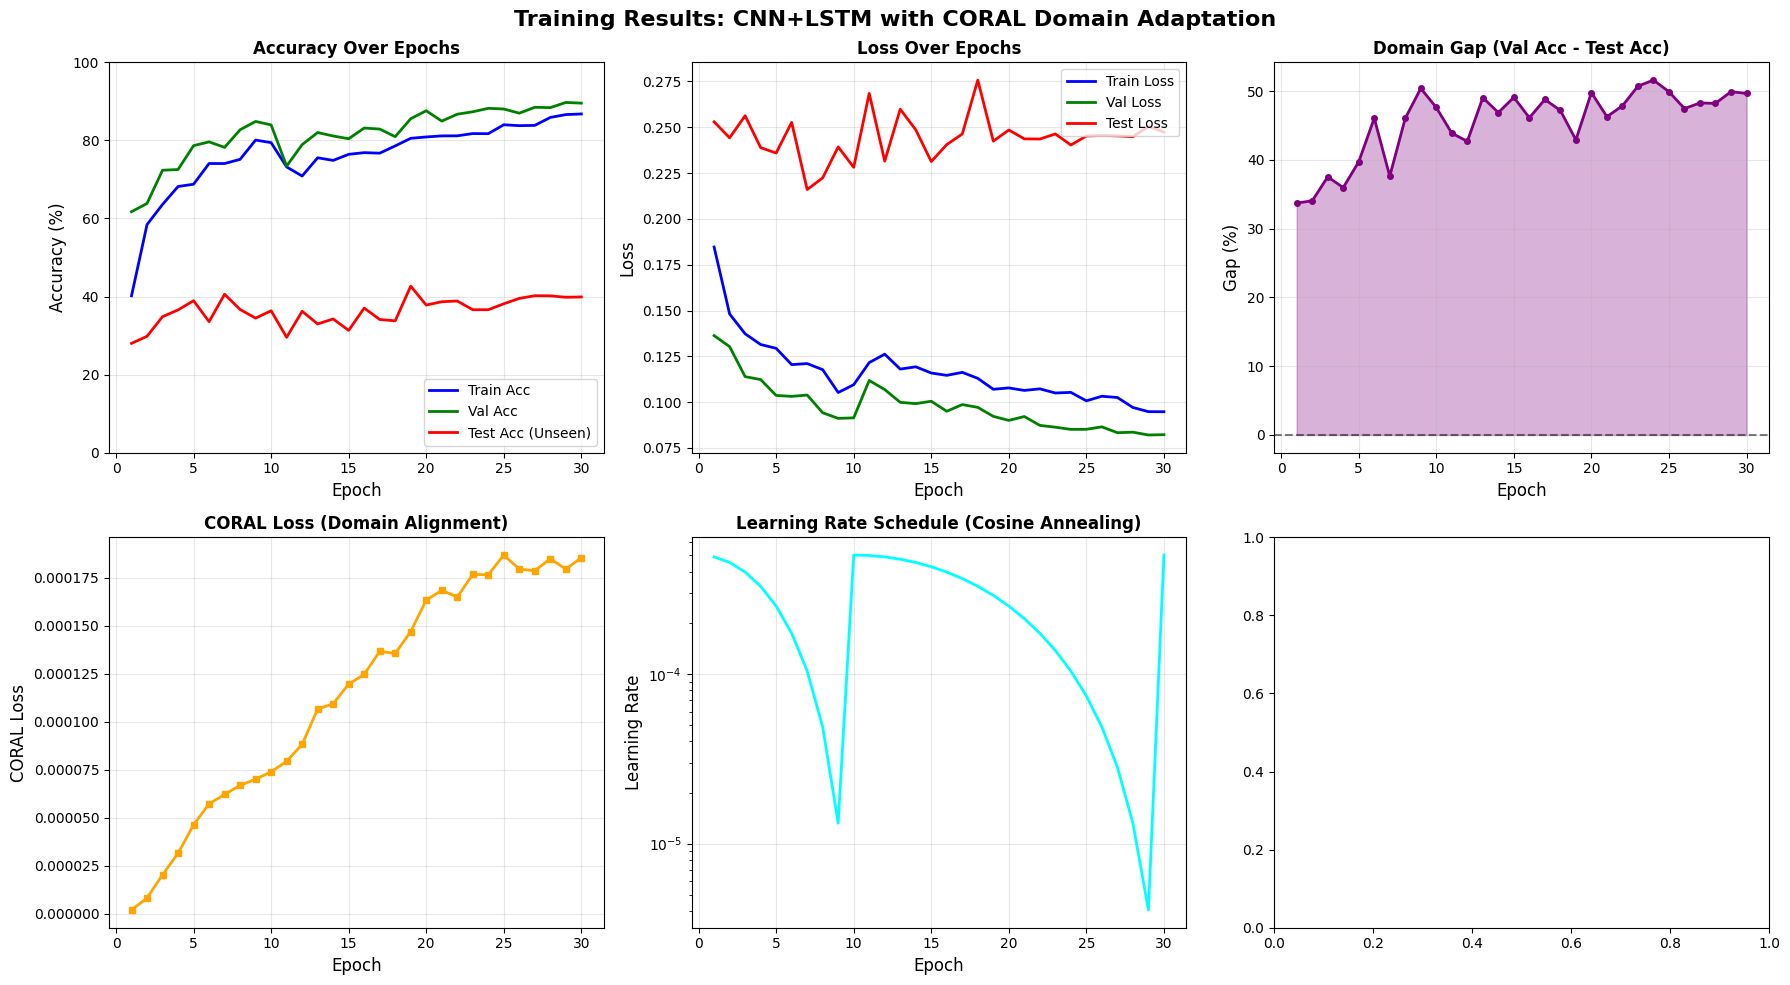

In [16]:
def plot_training_history(history):
    """
    Comprehensive visualization of training results.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training Results: CNN+LSTM with CORAL Domain Adaptation', fontsize=16, fontweight='bold')

    # Plot 1: Training, Validation, and Test Accuracy
    ax1 = axes[0, 0]
    ax1.plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    ax1.plot(epochs, history['val_acc'], 'g-', label='Val Acc', linewidth=2)
    ax1.plot(epochs, history['test_acc'], 'r-', label='Test Acc (Unseen)', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy (%)', fontsize=12)
    ax1.set_title('Accuracy Over Epochs', fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 100])

    # Plot 2: Training, Validation, and Test Loss
    ax2 = axes[0, 1]
    ax2.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax2.plot(epochs, history['val_loss'], 'g-', label='Val Loss', linewidth=2)
    ax2.plot(epochs, history['test_loss'], 'r-', label='Test Loss', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Loss Over Epochs', fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Domain Gap (Val - Test)
    ax3 = axes[0, 2]
    domain_gap = [v - t for v, t in zip(history['val_acc'], history['test_acc'])]
    ax3.plot(epochs, domain_gap, 'purple', linewidth=2, marker='o', markersize=4)
    ax3.fill_between(epochs, domain_gap, alpha=0.3, color='purple')
    ax3.set_xlabel('Epoch', fontsize=12)
    ax3.set_ylabel('Gap (%)', fontsize=12)
    ax3.set_title('Domain Gap (Val Acc - Test Acc)', fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='k', linestyle='--', alpha=0.5)

    # Plot 4: CORAL Loss
    ax4 = axes[1, 0]
    ax4.plot(epochs, history['coral_loss'], 'orange', linewidth=2, marker='s', markersize=4)
    ax4.set_xlabel('Epoch', fontsize=12)
    ax4.set_ylabel('CORAL Loss', fontsize=12)
    ax4.set_title('CORAL Loss (Domain Alignment)', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # Plot 5: Learning Rate
    ax5 = axes[1, 1]
    ax5.plot(epochs, history['lr'], 'cyan', linewidth=2)
    ax5.set_xlabel('Epoch', fontsize=12)
    ax5.set_ylabel('Learning Rate', fontsize=12)
    ax5.set_title('Learning Rate Schedule (Cosine Annealing)', fontweight='bold')
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot training history
plot_training_history(history)

In [15]:
# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from Epoch {checkpoint['epoch'] + 1}")

# Final evaluation
_, final_test_acc, test_preds, test_labels = validate(model, test_loader, criterion, CONFIG)

print(f"\n📊 Final Test Results on Unseen Environment ({test_env}):")
print(f"   Accuracy: {final_test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds,
                           target_names=[f'{i} person(s)' for i in range(6)],
                           digits=3, zero_division=0))

Loaded best model from Epoch 29

📊 Final Test Results on Unseen Environment (empty_room):
   Accuracy: 39.82%

Classification Report:
              precision    recall  f1-score   support

 0 person(s)      0.943     0.500     0.653       198
 1 person(s)      0.454     0.609     0.520      1188
 2 person(s)      0.470     0.532     0.499       594
 3 person(s)      0.283     0.242     0.261       594
 4 person(s)      0.262     0.104     0.149       594
 5 person(s)      0.238     0.259     0.248       594

    accuracy                          0.398      3762
   macro avg      0.442     0.374     0.389      3762
weighted avg      0.391     0.398     0.381      3762



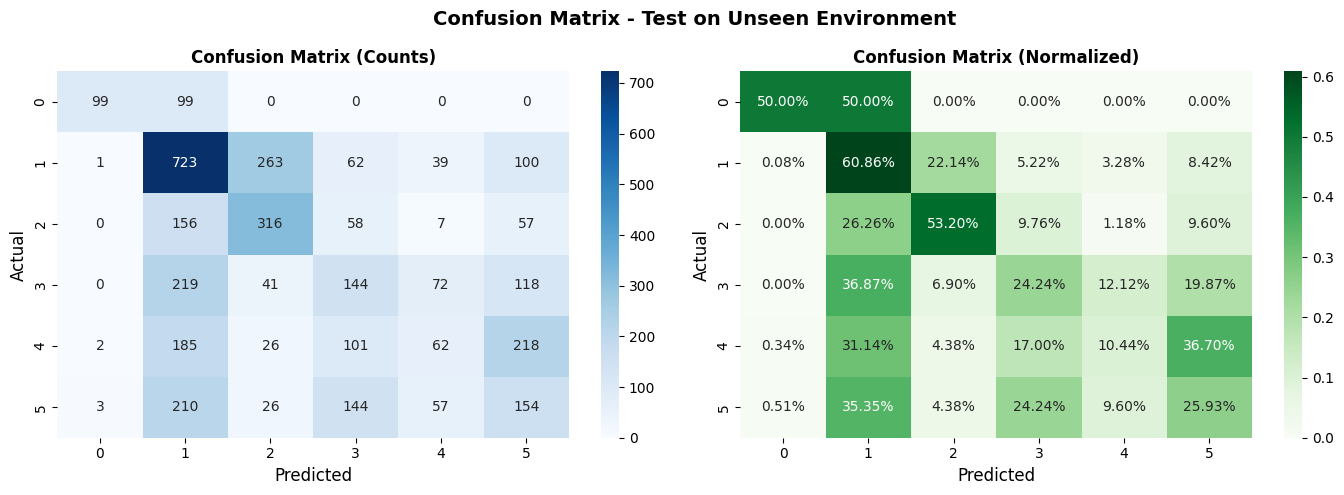


Per-Class Accuracy:
  0 person(s): 50.0%
  1 person(s): 60.9%
  2 person(s): 53.2%
  3 person(s): 24.2%
  4 person(s): 10.4%
  5 person(s): 25.9%


In [17]:
def plot_confusion_matrix(labels, preds, title='Confusion Matrix'):
    """
    Plot confusion matrix with detailed annotations.
    """
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=[f'{i}' for i in range(6)],
                yticklabels=[f'{i}' for i in range(6)])
    axes[0].set_xlabel('Predicted', fontsize=12)
    axes[0].set_ylabel('Actual', fontsize=12)
    axes[0].set_title('Confusion Matrix (Counts)', fontweight='bold')

    # Normalized
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
                xticklabels=[f'{i}' for i in range(6)],
                yticklabels=[f'{i}' for i in range(6)])
    axes[1].set_xlabel('Predicted', fontsize=12)
    axes[1].set_ylabel('Actual', fontsize=12)
    axes[1].set_title('Confusion Matrix (Normalized)', fontweight='bold')

    plt.suptitle(f'{title} - Test on Unseen Environment', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Per-class accuracy
    print("\nPer-Class Accuracy:")
    for i in range(6):
        class_acc = cm_normalized[i, i] * 100
        print(f"  {i} person(s): {class_acc:.1f}%")

plot_confusion_matrix(test_labels, test_preds)